Max weight: 0.3665749728679657
Min weight: -1.3241188526153564


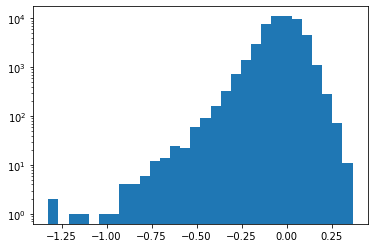

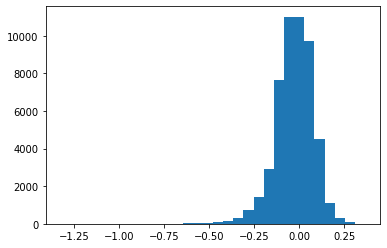

Max bias: 0.16357854008674622
Min bias: -0.23974871635437012


In [14]:
import glob
import matplotlib.pyplot as plt
import numpy as np

weights = []

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*weights.bin'):
    f = open(filename, mode="rb")

    weights = np.fromfile(f, dtype=np.float32)
    f.close()

print("Max weight: {0}".format(max(weights)))
print("Min weight: {0}".format(min(weights)))
plt.hist(weights, bins=30, log=True)
plt.show()
plt.hist(weights, bins=30)
plt.show()

biases = []

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*biases.bin'):
    f = open(filename, mode="rb")

    biases = np.fromfile(f, dtype=np.float32)
    f.close()

print("Max bias: {0}".format(max(biases)))
print("Min bias: {0}".format(min(biases)))

In [54]:
from tiny_imagenet import TinyImagenetDataset
import numpy as np

tiny_imagenet_builder = TinyImagenetDataset()
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

ds = tiny_imagenet_builder.as_dataset()["train"]
ds = ds.shuffle(1024)

activations = []

for image in ds.take(1000):
    activations.append(image['image'].numpy().flatten())

activations = map(inpu, activations)
print(activations)

[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([224, 224, 226, ..., 227, 227, 229], dtype=uint8), array([2, 3, 0, ..., 0, 1, 0], dtype=uint8), array([255, 255, 253, ..., 255, 255, 250], dtype=uint8), array([ 66,  67,  53, ..., 174, 164, 139], dtype=uint8), array([4, 4, 4, ..., 0, 0, 0], dtype=uint8), array([18,  0,  0, ...,  0,  6,  2], dtype=uint8), array([  0,   0,   0, ..., 102, 112, 103], dtype=uint8), array([63, 54, 59, ..., 31, 19, 21], dtype=uint8), array([113, 123, 114, ...,  53,  50,  57], dtype=uint8), array([166, 186, 223, ...,  76,  75,  70], dtype=uint8), array([ 32,   0,   0, ..., 223, 208, 189], dtype=uint8), array([139, 141, 140, ..., 206, 178, 138], dtype=uint8), array([164, 180, 213, ..., 206, 221, 244], dtype=uint8), array([64, 64, 64, ..., 72, 72, 72], dtype=uint8), array([ 71,  55,  40, ..., 188, 161,  80], dtype=uint8), array([148, 137, 141, ..., 242, 240, 228], dtype=uint8), array([198, 195, 190, ..., 125, 117,  98], dtype=uint8), array([213, 155